# Kenar Entertainment Sentiment Analysis

## Set up environment

In [31]:
import os
from dotenv import find_dotenv, load_dotenv
import tweepy
import pandas as pd
import re
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
import nltk
import numpy as np
from PIL import Image
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt


nltk.download('vader_lexicon')
dotenv_path = find_dotenv()
load_dotenv(dotenv_path)

CLIENT_ID = os.getenv("CLIENT_ID")
CLIENT_SECRET = os.getenv("CLIENT_SECRET")
API_KEY = os.getenv("API_KEY")
API_KEY_SECRET = os.getenv("API_KEY_SECRET")
BEARER_TOKEN = os.getenv("BEARER_TOKEN")
ACCESS_TOKEN = os.getenv("ACCESS_TOKEN")
ACCESS_TOKEN_SECRET = os.getenv("ACCESS_TOKEN_SECRET")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Authentication

### API v1.1

In [32]:
# auth1 = tweepy.OAuth1UserHandler(API_KEY, API_KEY_SECRET, ACCESS_TOKEN, ACCESS_TOKEN_SECRET)
# api1 = tweepy.API(auth1)

# tweets = api1.home_timeline(count = 5)
# for tweet in tweets:
#     print(tweet.text, '\n')

### API v2.0

In [33]:
api2 = tweepy.Client(bearer_token=BEARER_TOKEN)

query = '#chelsea -is:retweet lang:en'

# tweets = api2.search_recent_tweets(query=query, tweet_fields = ['context_annotations', 'created_at'], max_results=10)
# for tweet in tweets.data:
#     print('\n___Tweet Text___\n' , tweet.text)

paginator = tweepy.Paginator(
    api2.search_recent_tweets,
    query = query,
    max_results=100,
    limit=10
)

tweet_list = []

for tweet in paginator.flatten():
    tweet_list.append(tweet)

In [34]:
tweet_list_df = pd.DataFrame(tweet_list)
tweet_list_df = pd.DataFrame(tweet_list_df['text'])
tweet_list_df.head(5)

,text
0,RT @fan_banter: Away Attendances at the Weeken...
1,👋😁 LETS MAKE IT EASIER FOR #CHELSEA FANS TO F...
2,Next page »Arsenal’s players should be i...\n\...
3,🚨 #Chelsea want Declan Rice.\n\n{via @JacobsBe...
4,The Premier League season will soon pau...\n\n...


## Data Preprocessing

In [35]:
from util import preprocess_tweet
cleaned_tweets = []

for tweet in tweet_list_df['text']:
  cleaned_tweet = preprocess_tweet(tweet)
  cleaned_tweets.append(cleaned_tweet)

In [36]:
tweet_list_df['cleaned'] = pd.DataFrame(cleaned_tweets)
tweet_list_df.head(5)

,text,cleaned
0,RT @fan_banter: Away Attendances at the Weeken...,rt banter away attendances at the weekend 21st...
1,👋😁 LETS MAKE IT EASIER FOR #CHELSEA FANS TO F...,lets make it easier for chelsea fans to find ...
2,Next page »Arsenal’s players should be i...\n\...,next page arsenal players should be premierlea...
3,🚨 #Chelsea want Declan Rice.\n\n{via @JacobsBe...,chelsea want declan rice via cfc
4,The Premier League season will soon pau...\n\n...,the premier league season will soon pau mancit...


## Generate Sentiment Labels

In [37]:
#Calculating Negative, Positive, Neutral and Compound values

tweet_list_df[['polarity', 'subjectivity']] = tweet_list_df['cleaned'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))
for index, row in tweet_list_df['cleaned'].iteritems():
    score = SentimentIntensityAnalyzer().polarity_scores(row)
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']
    if comp <= -0.05:
        tweet_list_df.loc[index, 'sentiment'] = "negative"
    elif comp >= 0.05:
        tweet_list_df.loc[index, 'sentiment'] = "positive"
    else:
        tweet_list_df.loc[index, 'sentiment'] = "neutral"
    tweet_list_df.loc[index, 'neg'] = neg
    tweet_list_df.loc[index, 'neu'] = neu
    tweet_list_df.loc[index, 'pos'] = pos
    tweet_list_df.loc[index, 'compound'] = comp

tweet_list_df.head(5)

C:\Users\User\AppData\Local\Temp\ipykernel_9652\1897720740.py:4: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, row in tweet_list_df['cleaned'].iteritems():


,text,cleaned,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,RT @fan_banter: Away Attendances at the Weeken...,rt banter away attendances at the weekend 21st...,0.000,0.000,positive,0.0,0.928,0.072,0.4215
1,👋😁 LETS MAKE IT EASIER FOR #CHELSEA FANS TO F...,lets make it easier for chelsea fans to find ...,-0.125,0.375,positive,0.0,0.843,0.157,0.4215
2,Next page »Arsenal’s players should be i...\n\...,next page arsenal players should be premierlea...,0.000,0.000,neutral,0.0,1.000,0.000,0.0000
3,🚨 #Chelsea want Declan Rice.\n\n{via @JacobsBe...,chelsea want declan rice via cfc,0.000,0.000,positive,0.0,0.794,0.206,0.0772
4,The Premier League season will soon pau...\n\n...,the premier league season will soon pau mancit...,0.000,0.000,neutral,0.0,1.000,0.000,0.0000


## Sentiment Visualization

In [38]:
#Creating new data frames for all sentiments (positive, negative and neutral)

tweet_list_df_negative = tweet_list_df[tweet_list_df["sentiment"]=="negative"]
tweet_list_df_positive = tweet_list_df[tweet_list_df["sentiment"]=="positive"]
tweet_list_df_neutral = tweet_list_df[tweet_list_df["sentiment"]=="neutral"]

### Donut Chart

In [39]:
#Function for count_values_in single columns

def count_values_in_column(data,feature):
    total=data.loc[:,feature].value_counts(dropna=False)
    percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
    return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])

In [40]:
#Count_values for sentiment
count_values_in_column(tweet_list_df,"sentiment")

,Total,Percentage
positive,522,52.2
neutral,362,36.2
negative,116,11.6


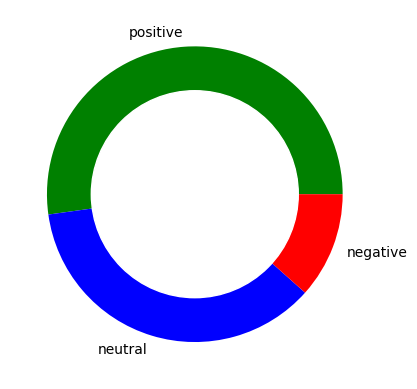

In [41]:
# create data for Pie Chart
pichart = count_values_in_column(tweet_list_df,"sentiment")
# names= pc.index
# size=pc["Percentage"]

names= pichart.index
size=pichart["Percentage"]

# Create a circle for the center of the plot
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(size, labels=names, colors=['green','blue','red'])
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

### World Cloud

In [54]:
def create_wordcloud(text):
    mask = np.array(Image.open("./resources/cloud.png"))
    stopwords = set(STOPWORDS)
    wc = WordCloud(background_color="white",
                  mask = mask,
                  max_words=100,
                  stopwords=stopwords,
                  repeat=True)
    wc.generate(str(text))
    path="outputs/c1_wordcloud.png"
    wc.to_file(path)
    print("Word Cloud Saved Successfully")
    display(Image.open(path))


Word Cloud Saved Successfully


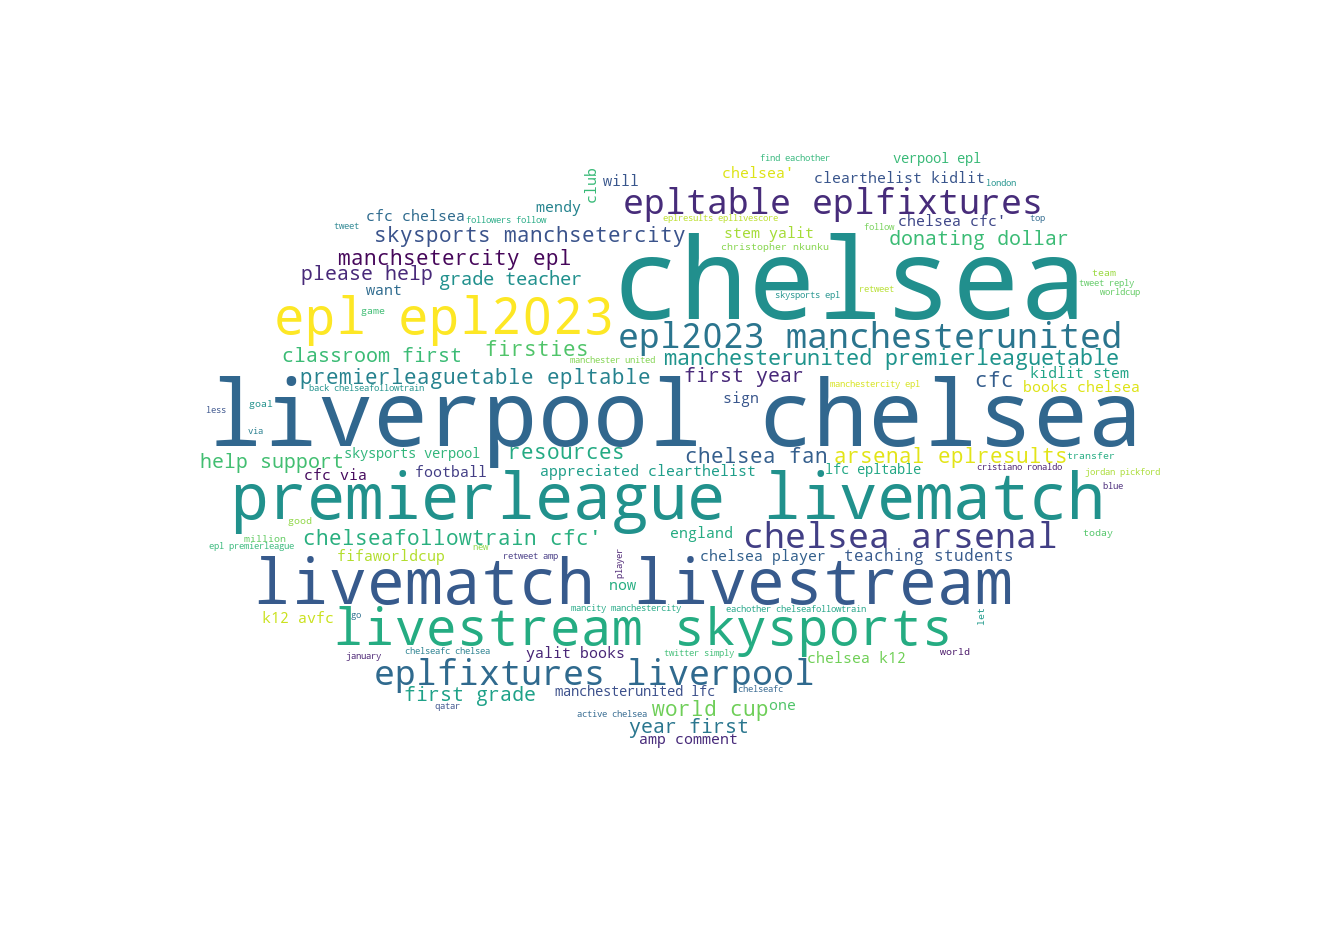

In [55]:
# from util import create_wordcloud
create_wordcloud(tweet_list_df["cleaned"].values)
# create_wordcloud(tweet_list_df_positive["cleaned"].values)
# create_wordcloud(tweet_list_df_negative["cleaned"].values)
# create_wordcloud(tweet_list_df_neutral["cleaned"].values)

### Text Insights

In [56]:
#Calculating tweet's lenght and word count
tweet_list_df['text_len'] = tweet_list_df['cleaned'].astype(str).apply(len)
tweet_list_df['text_word_count'] = tweet_list_df['cleaned'].apply(lambda x: len(str(x).split()))

In [57]:
round(pd.DataFrame(tweet_list_df.groupby("sentiment").text_len.mean()),2)

,text_len
sentiment,
negative,154.11
neutral,145.16
positive,158.94


In [58]:
round(pd.DataFrame(tweet_list_df.groupby("sentiment").text_word_count.mean()),2)

,text_word_count
sentiment,
negative,24.68
neutral,19.06
positive,25.35


## Saving Output Tweets File to Drive

In [59]:
tweet_list_df.to_csv("./outputs/c2_sentimentanalysis_output.csv", sep=',', encoding='UTF-8')
tweet_list_df.head(5)

,text,cleaned,polarity,subjectivity,sentiment,neg,neu,pos,compound,text_len,text_word_count
0,RT @fan_banter: Away Attendances at the Weeken...,rt banter away attendances at the weekend 21st...,0.000,0.000,positive,0.0,0.928,0.072,0.4215,216,37
1,👋😁 LETS MAKE IT EASIER FOR #CHELSEA FANS TO F...,lets make it easier for chelsea fans to find ...,-0.125,0.375,positive,0.0,0.843,0.157,0.4215,83,16
2,Next page »Arsenal’s players should be i...\n\...,next page arsenal players should be premierlea...,0.000,0.000,neutral,0.0,1.000,0.000,0.0000,191,20
3,🚨 #Chelsea want Declan Rice.\n\n{via @JacobsBe...,chelsea want declan rice via cfc,0.000,0.000,positive,0.0,0.794,0.206,0.0772,33,6
4,The Premier League season will soon pau...\n\n...,the premier league season will soon pau mancit...,0.000,0.000,neutral,0.0,1.000,0.000,0.0000,199,22
